This script does a few things and desperately needs cleaning up. 

It:


*   Does SSIM clustering to approximate covariate shift between source and target datasets. Visualises this.
*   Builds a model capable of semantically segmenting flood image patches, with training and evaluation which can be visualised in Tensorboard.
* Visualises segmentation maps from the classifier, compares them to the not really ground truth labels (from Copernicus EMS)
 


In [0]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
from google.colab import auth
import matplotlib.pyplot as plt
from skimage.measure import compare_ssim
from scipy.stats import gaussian_kde
import seaborn as sns

import asset_paths_to_cop_data as fc_paths
from ml_input_pipeline import InputPipeline

auth.authenticate_user()
tf.enable_eager_execution()

**Do some SSIM clustering to approximate covariate shift. **

In [0]:
# train_dataset, test_dataset = InputPipeline().call(fc_paths,set_up)
input_pipeline = InputPipeline()
input_files = input_pipeline.get_tfrecord_paths(fc_paths)
np.random.shuffle(input_files)
source_d = input_pipeline.make_source_dataset(input_files)
target_d = input_pipeline.make_target_dataset(input_files)

source_dataset = source_d.map(input_pipeline._parse_function).shuffle(5000, seed=2)
target_dataset = target_d.map(input_pipeline._parse_function).shuffle(5000, seed=2)

['gs://labelled_data/EMSR130_09MONYO_01DELINEATION_v1_110000_area_of_interest.tfrecord', 'gs://labelled_data/EMSR130_16IRRAWADDYDELTA_01DELINEATION_MONIT03_v1_600000_area_of_interest00004.tfrecord', 'gs://labelled_data/EMSR130_16IRRAWADDYDELTA_01DELINEATION_MONIT03_v1_600000_area_of_interest00006.tfrecord', 'gs://labelled_data/EMSR130_06PATHEIN_01DELINEATION_v1_110000_area_of_interest.tfrecord', 'gs://labelled_data/EMSR130_16IRRAWADDYDELTA_01DELINEATION_MONIT03_v1_600000_area_of_interest00008.tfrecord', 'gs://labelled_data/EMSR130_16IRRAWADDYDELTA_01DELINEATION_MONIT03_v1_600000_area_of_interest00005.tfrecord', 'gs://labelled_data/EMSR277_01ORESTIADA_DEL_v2_area_of_interest_a.tfrecord', 'gs://labelled_data/EMSR130_16IRRAWADDYDELTA_01DELINEATION_MONIT03_v1_600000_area_of_interest00003.tfrecord', 'gs://labelled_data/EMSR130_16IRRAWADDYDELTA_01DELINEATION_MONIT03_v1_600000_area_of_interest00007.tfrecord', 'gs://labelled_data/EMSR122_03ACHINOS_01DELINEATION_MONIT01_v2_19000_area_of_interes

In [0]:
def distance_cluster(distribution_a, distribution_b):
  return compare_ssim(distribution_a,distribution_b)
#   return tf.distributions.kl_divergence(distribution_a, distribution_b)

In [0]:
batch_size = 10
source_data = source_dataset.take(300).shuffle(300).batch(1)
source_data2 = source_dataset.skip(300).take(300).shuffle(300).batch(1)
target_data = target_dataset.take(300).shuffle(300).batch(1)

# source_data = source_dataset.shuffle(75).repeat().batch(batch_size)
# source_data2 = source_dataset.shuffle(75).repeat().batch(batch_size)
# target_data = target_dataset.shuffle(10).repeat().batch(batch_size)
# if we do this on a batch level and it is shuffled properly then we can just collect the distance score at the end of each iteration and push it into a list.
source_only_scores = []
source_target_scores = []
ct = 0
for ((xs, ys), (xss,yss), (xt,yt)) in tfe.Iterator(tf.data.Dataset.zip((source_data, source_data2, target_data))):
  xs = tf.reshape(xs,[256,256]).numpy()
  xss = tf.reshape(xss,[256,256]).numpy()
  xt = tf.reshape(xt,[256,256]).numpy()

  s2s = distance_cluster(xs,xss)

  s2t = distance_cluster(xs,xt)
  
  ct +=1
  
  if ct > 250:
    break
      
  source_only_scores.append(s2s)
  source_target_scores.append(s2t)
  
print(source_only_scores)
print(source_target_scores)

In [0]:
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] 

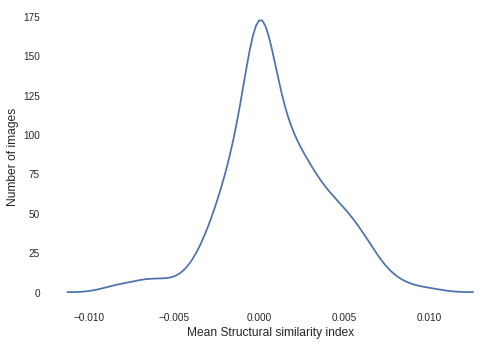

In [0]:
# source_only_scores = source_only_scores[source_only_scores < 0.5]
source_only_scores = np.array(source_only_scores)
plt.xlabel('Mean Structural similarity index', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
sns.distplot(source_only_scores[source_only_scores < 0.5], hist = False, kde = True)


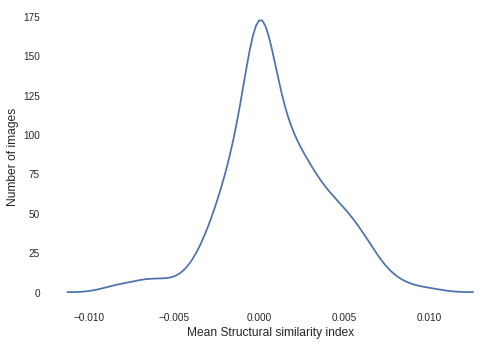

In [0]:
# source_only_scores = source_only_scores[source_only_scores < 0.5]
source_only_scores = np.array(source_only_scores)
plt.xlabel('Mean Structural similarity index', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
sns.distplot(source_only_scores[source_only_scores < 0.5], hist = False, kde = True)


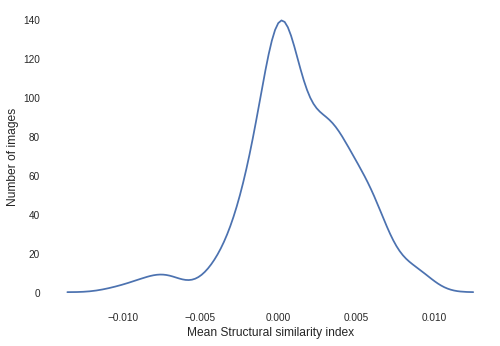

In [0]:
plt.xlabel('Mean Structural similarity index', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
sns.distplot(source_target_scores, hist = False, kde = True)


**Define the methods we will need for our main CNN to segment the images.**

In [0]:
class Simpler_fcn(tf.keras.Model):
  def __init__(self):
    super(Simpler_fcn, self).__init__()
    self.conv_layer = tf.keras.layers.Conv2D(8,5,1,activation=tf.nn.relu)
#     self.batch_norm = tf.keras.layers.BatchNormalization()
    self.mid_layer = tf.keras.layers.Conv2D(2,1,1)
    self.deconv_layer = tf.keras.layers.Conv2DTranspose(2,5,1, padding='valid',
                  kernel_regularizer=tf.contrib.layers.l2_regularizer(0.))


  def call(self, x):
    # Forward-pass logic
    hidden_layer_output = self.conv_layer(x)
    mid_layer_output = self.mid_layer(hidden_layer_output)

    final_output = self.deconv_layer(mid_layer_output)

    return final_output 

In [0]:
def reshape_output(net, inputs, labels):
  one_hot_labels = tf.one_hot(tf.cast(labels,tf.int32), depth=2)
   
  logits = tf.reshape(net(inputs), [-1,256,256, 2], name='logits')
  labels = tf.reshape(one_hot_labels,[-1,256,256,2], name='labels')
  logits = tf.cast(logits, tf.float32)
  
  return logits, labels
  

In [0]:
def weight_logits_by_class_prevalence(logits):
  ratio = 5.0 / (95.0 + 5.0)
  class_weight = tf.constant([ratio, 1.0 - ratio],tf.float32)
  return tf.math.multiply(logits, class_weight) # shape [batch_size, 2] jst works cos of broadcasting...


In [0]:
def get_predictions(net, inputs):
  logits = tf.reshape(net(inputs), [-1,256,256, 2], name='logits')
  weighted_logits = weight_logits_by_class_prevalence(logits)
  predictions = tf.nn.softmax(weighted_logits)[..., 1]
  return predictions  

In [0]:
def compute_accuracy(logits,labels,string):
  labels = tf.argmax(labels, axis=3) # anti one hot

  predictions = tf.nn.softmax(logits)[..., 1]
  f1_score = tf.contrib.metrics.f1_score(labels,predictions)
  
  tf.contrib.summary.scalar('f1_score'+string,f1_score)
  #   tf.contrib.summary.scalar('accuracy'+string,tf.contrib.metrics.accuracy(tf.cast(tf.round(predictions),tf.int32), tf.cast(anti_one_hot,tf.int32 )))

  return f1_score

In [0]:
def loss_f(net, inputs, labels,string):
  
  logits, labels = reshape_output(net, inputs, labels)
  
  weighted_logits = weight_logits_by_class_prevalence(logits)

  compute_accuracy(weighted_logits,labels,string) ### REFACTOR this
 
  entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=weighted_logits)
  
  return tf.reduce_mean(entropy)

In [0]:
def train_step(loss_f, net, opt, x, y):
  opt.minimize(lambda: loss_f(net, x, y,'_train'),global_step=tf.train.get_or_create_global_step())

Setting up ngrok for tunneling to run Tensorboard - only necessary when using Colab and should be fine if you running locally.

In [0]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip


--2019-02-28 13:02:10--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.7.169.168, 52.54.84.112, 52.72.250.2, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.7.169.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  19.7MB/s    in 0.3s    

2019-02-28 13:02:11 (19.7 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
# Set up tunneling for Tensorboard

LOG_DIR = 'tmp/out/'

get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6007 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6007 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://70a1a929.ngrok.io


In [0]:
train_writer = tf.contrib.summary.create_file_writer(LOG_DIR+'/run1/train')
test_writer = tf.contrib.summary.create_file_writer(LOG_DIR+'/run1/test')
# 

In [0]:
def always_flood(x):
  return np.repeat(np.ones(x.shape), 2, axis=-1)*np.asarray([0,1])

def always_nonflood(x):
  return np.repeat(np.ones(x.shape), 2, axis=-1)*np.asarray([1,0])

**Choose the Set-up!**

In [0]:
set_up = 'Naive Transfer'


In [0]:
## train only

train_dataset, test_dataset = InputPipeline().call(fc_paths,set_up)
simple_net = Simpler_fcn()

opt = tf.train.AdamOptimizer(learning_rate=0.01)
train_dataset_size = 21765
batch_size = 30 #FUCK I CANNOT MAKE A BIGGER BATCH SIZE BECAUSE OF OOM
batches_in_epoch = np.ceil(train_dataset_size/batch_size)

step = 0
epoch = 0

train_data = train_dataset.shuffle(750).repeat().batch(10)
test_data = test_dataset.shuffle(50).repeat().batch(10)


['gs://labelled_data/EMSR130_16IRRAWADDYDELTA_01DELINEATION_MONIT03_v1_600000_area_of_interest00009.tfrecord', 'gs://labelled_data/EMSR130_16IRRAWADDYDELTA_01DELINEATION_MONIT03_v1_600000_area_of_interest00008.tfrecord', 'gs://labelled_data/EMSR130_16IRRAWADDYDELTA_01DELINEATION_MONIT03_v1_600000_area_of_interest00007.tfrecord', 'gs://labelled_data/EMSR150_03CROSSHILLS_01DELINEATION_v1_40000_area_of_interest.tfrecord', 'gs://labelled_data/EMSR130_16IRRAWADDYDELTA_01DELINEATION_MONIT03_v1_600000_area_of_interest00005.tfrecord', 'gs://labelled_data/EMSR130_10PYAY_01DELINEATION_v1_110000_area_of_interest.tfrecord', 'gs://labelled_data/EMSR150_08LEEDS_01DELINEATION_v1_40000_area_of_interest.tfrecord', 'gs://labelled_data/EMSR130_11YANGONWEST_01DELINEATION_v1_110000_area_of_interest.tfrecord', 'gs://labelled_data/EMSR122_03ACHINOS_01DELINEATION_MONIT01_v2_19000_area_of_interest.tfrecord', 'gs://labelled_data/EMSR130_04PATHWE_01DELINEATION_v2_110000_area_of_interest.tfrecord', 'gs://labelled

In [0]:
## train a bit only

for ((xb, yb), (xt,yt)) in tfe.Iterator(tf.data.Dataset.zip((train_data, test_data))):
  if epoch > 2:
    break

  if step%batches_in_epoch==0:
    epoch+=1
    print("epoch",epoch)
    
  result = train_step(loss_f, simple_net, opt, xb, yb)
  
  if step % 100 == 0:
    print(step)
  step+=1


Instructions for updating:
Colocations handled automatically by placer.
epoch 1
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

0
100
200
300
400
500
600
700
epoch 2
800
900
1000
1100
1200
1300
1400
epoch 3


In [0]:

# train with tensorboard, to viz loss and accuracy otherwise use above

train_dataset, test_dataset = InputPipeline().call(fc_paths,set_up)

simple_net = Simpler_fcn()

opt = tf.train.AdamOptimizer(learning_rate=0.01)
train_dataset_size = 21765
batch_size = 30 #FUCK I CANNOT MAKE A BIGGER BATCH SIZE BECAUSE OF OOM
batches_in_epoch = np.ceil(train_dataset_size/batch_size)

with train_writer.as_default():
  with tf.contrib.summary.always_record_summaries():
    step = 0
    epoch = 0
    
    train_data = train_dataset.shuffle(750).repeat().batch(batch_size)
    test_data = test_dataset.shuffle(50).repeat().batch(batch_size)
    for ((xb, yb), (xt,yt)) in tfe.Iterator(tf.data.Dataset.zip((train_data, test_data))):
      
      if epoch > 5:
        break
        
      if step%batches_in_epoch==0:
        epoch+=1
        print("epoch",epoch)

      step+=1
      
      tf.contrib.summary.scalar('train_loss_Baseline', loss_f(always_nonflood, xb,yb,'_train_baseline'))
      tf.contrib.summary.scalar('train_loss_value', loss_f(simple_net, xb,yb,'_train'))
      result = train_step(loss_f, simple_net, opt, xb, yb)
      tf.contrib.summary.scalar('test_loss_value', loss_f(simple_net,xt,yt,'_test'))
      tf.contrib.summary.scalar('test_loss_Baseline', loss_f(always_nonflood,xt,yt,'_test_baseline'))
        

**Plot segmentation maps (assumes model has been trained and saved in global state)**

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


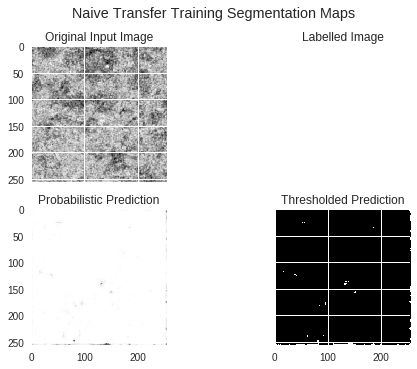

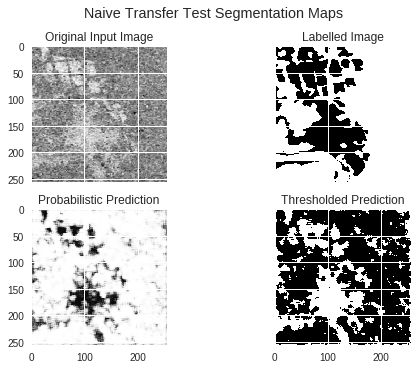

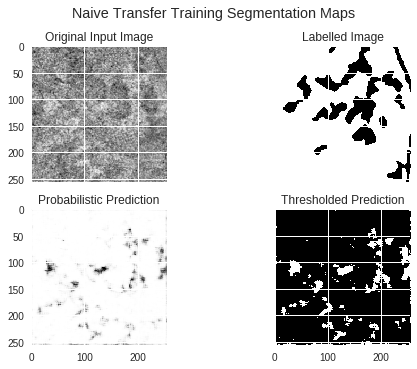

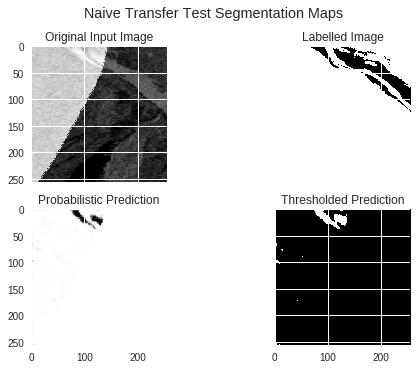

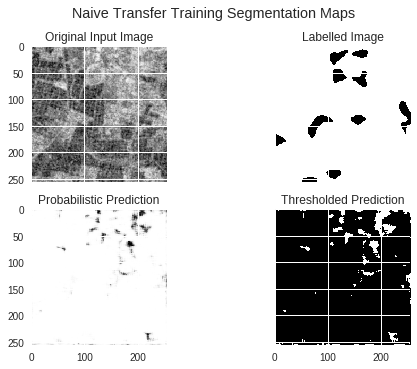

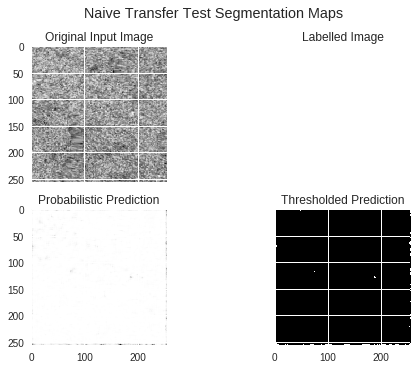

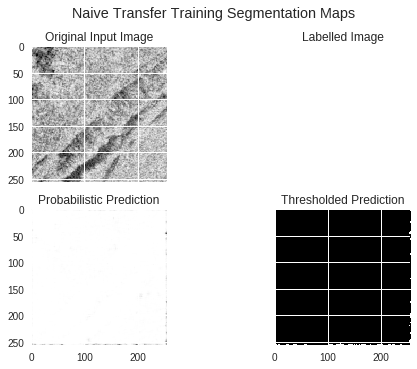

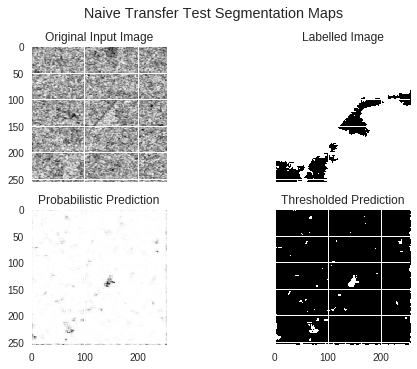

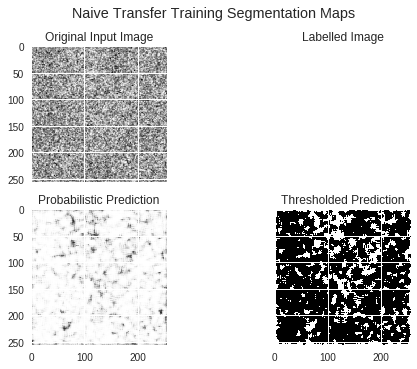

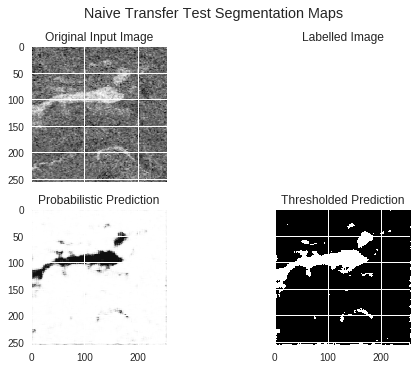

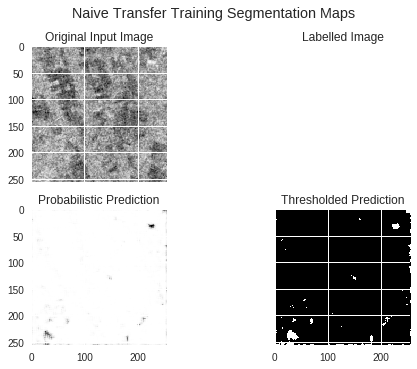

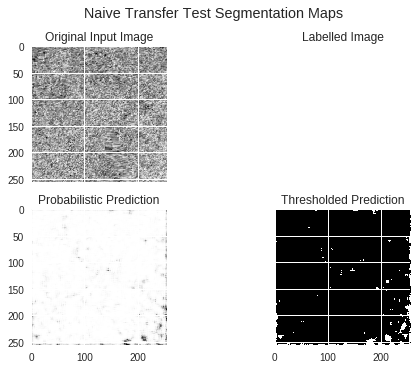

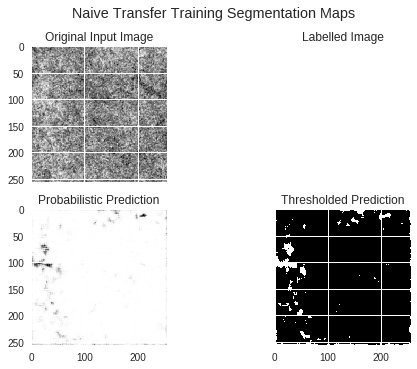

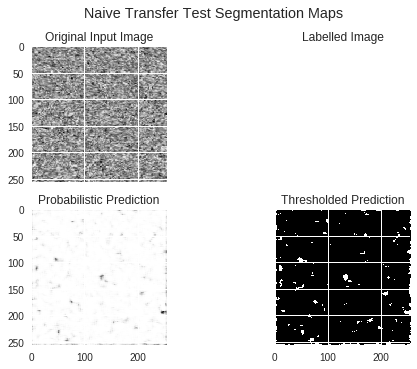

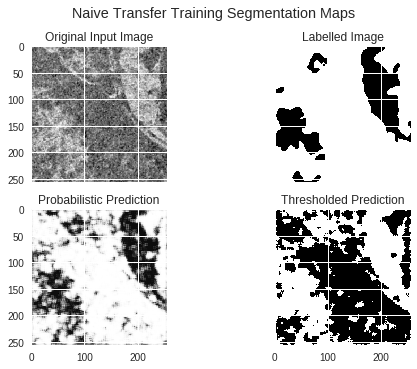

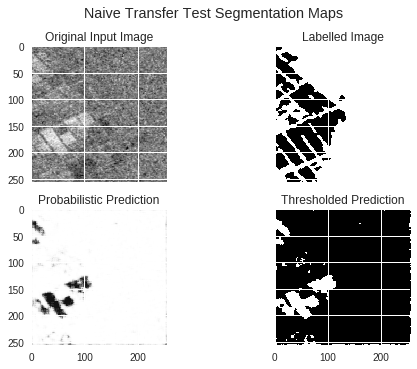

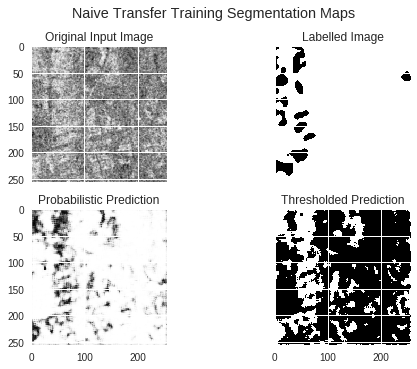

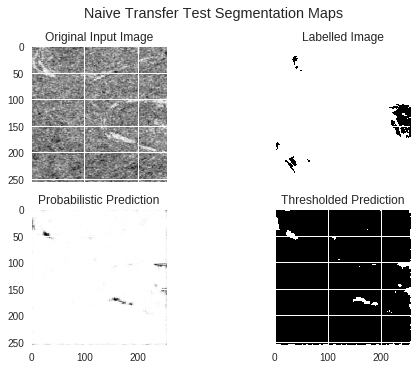

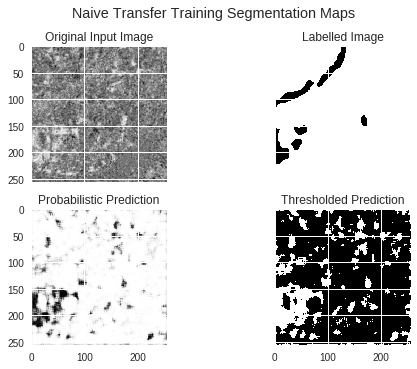

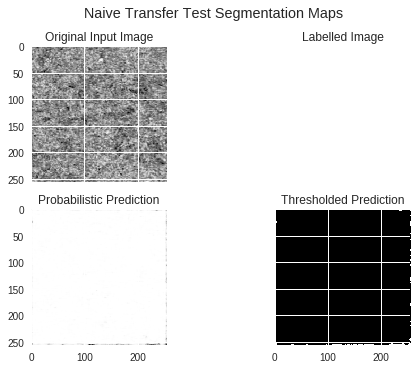

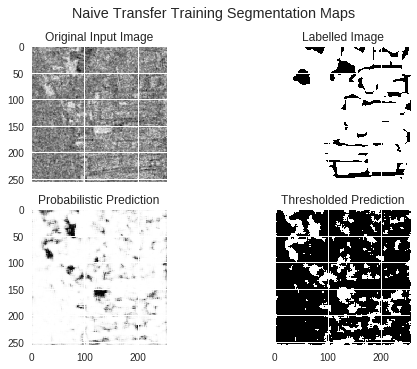

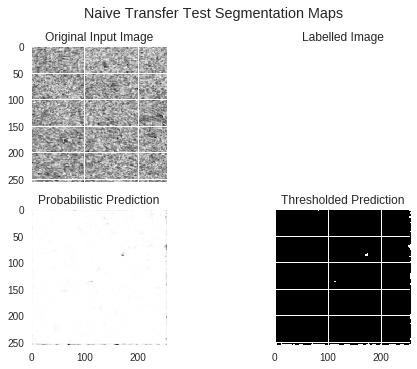

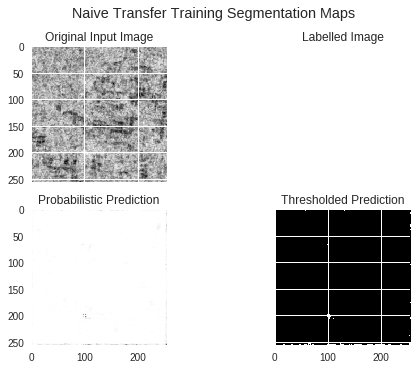

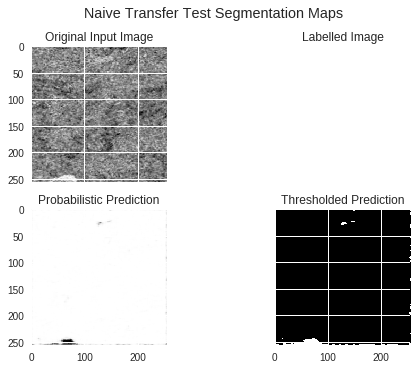

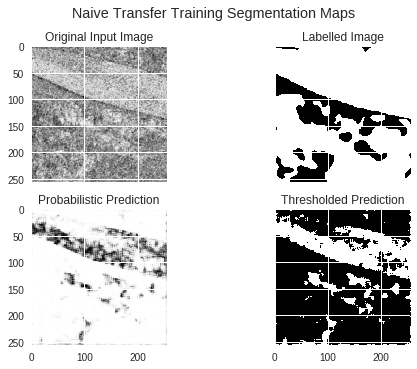

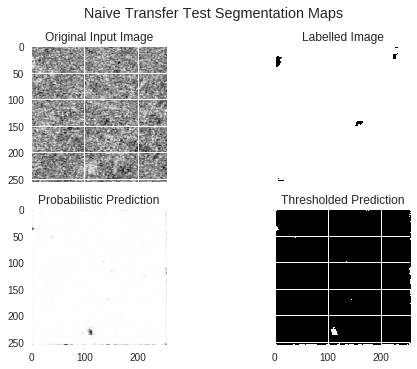

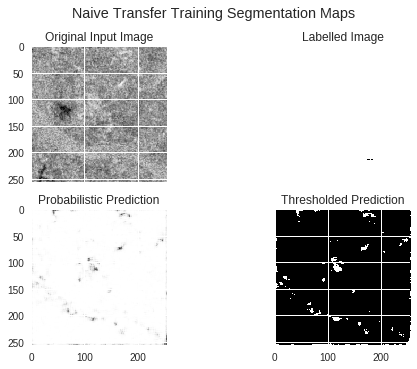

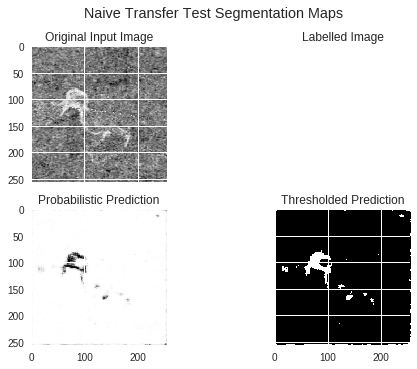

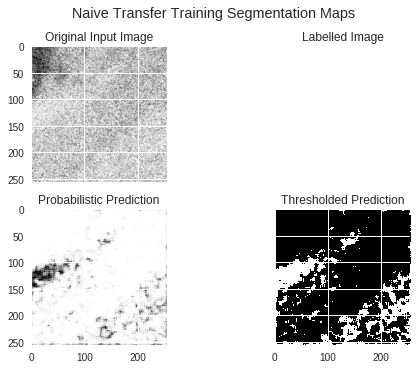

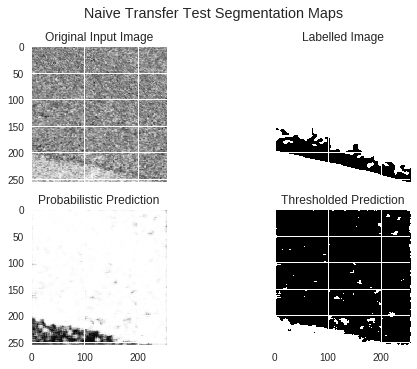

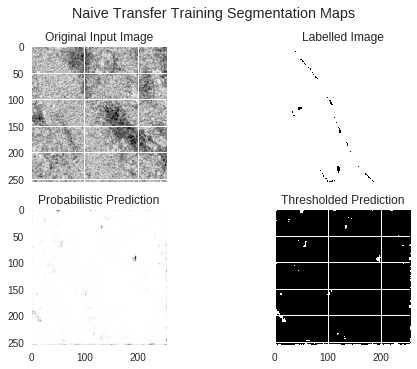

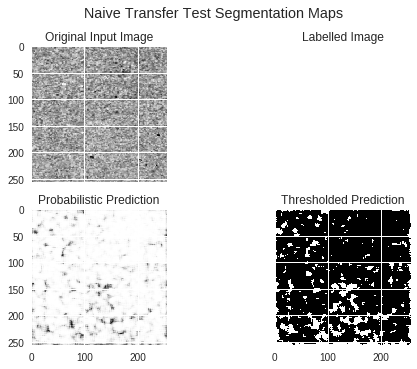

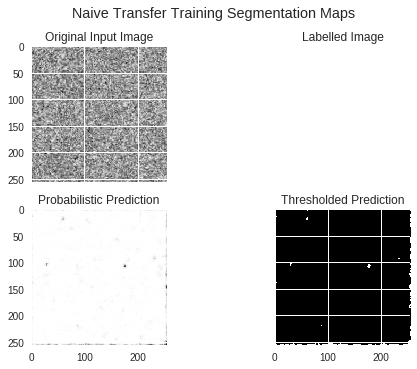

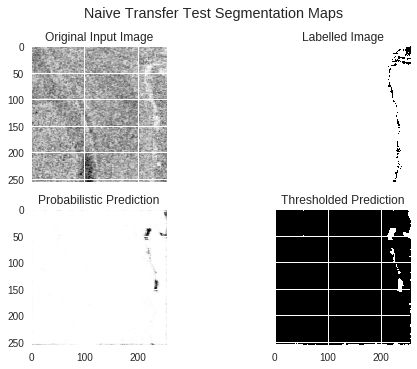

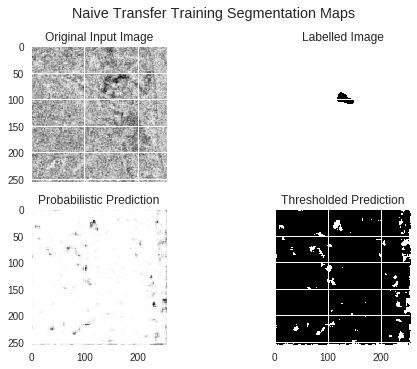

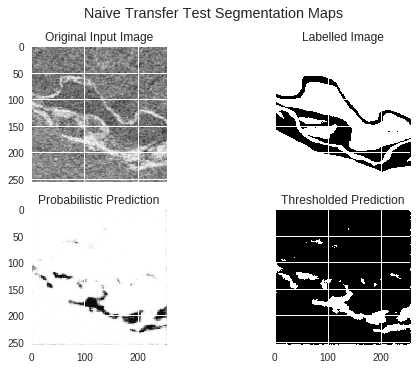

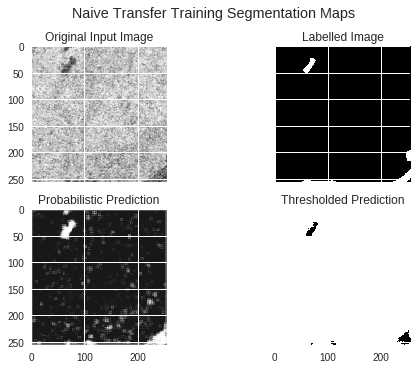

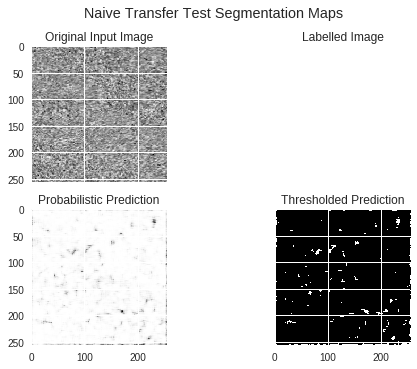

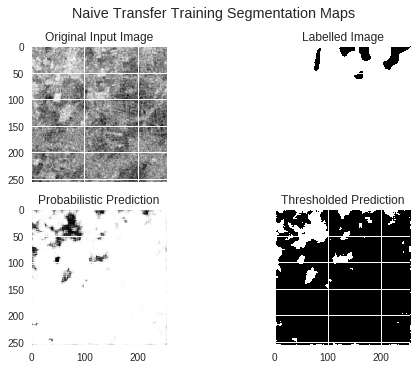

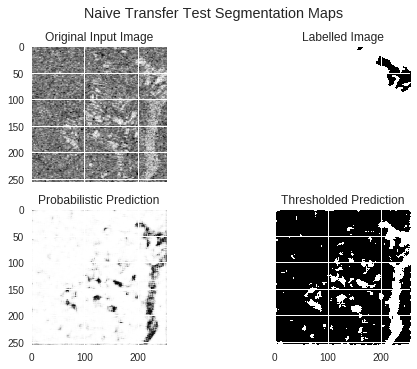

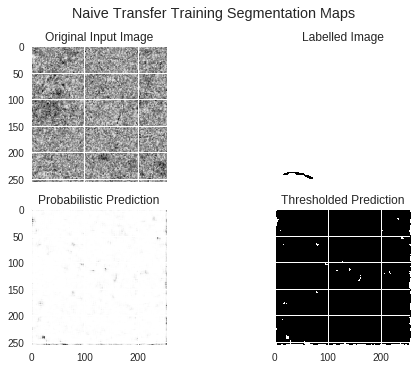

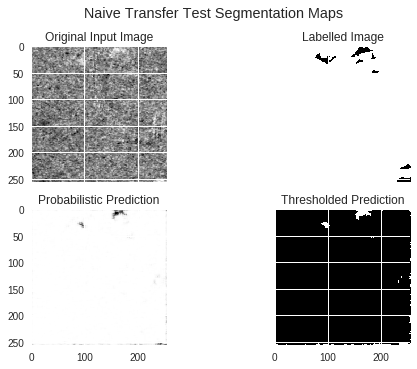

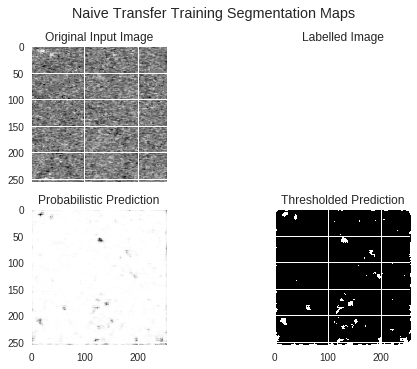

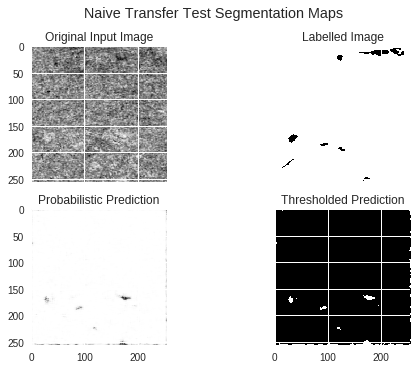

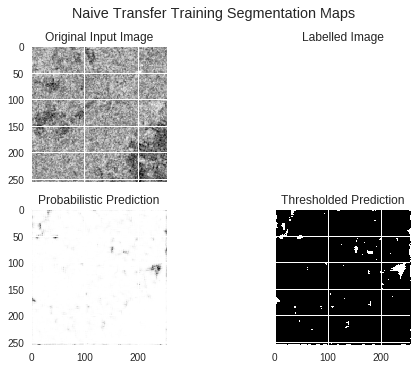

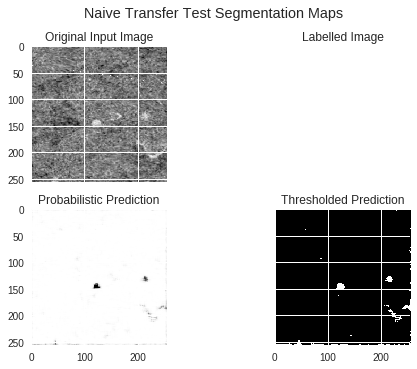

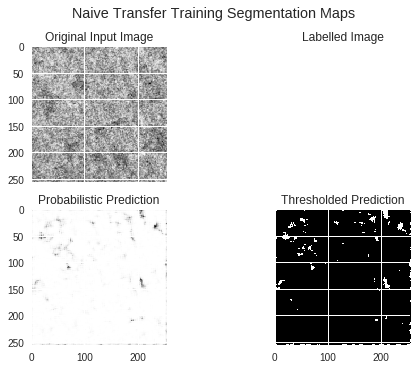

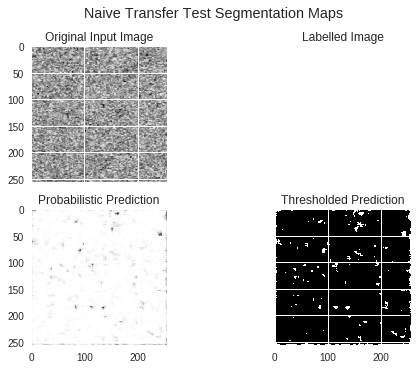

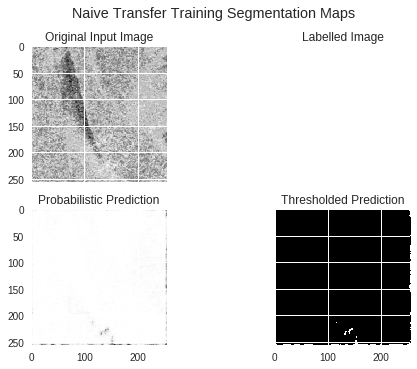

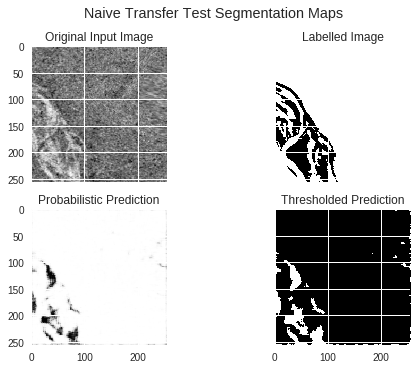

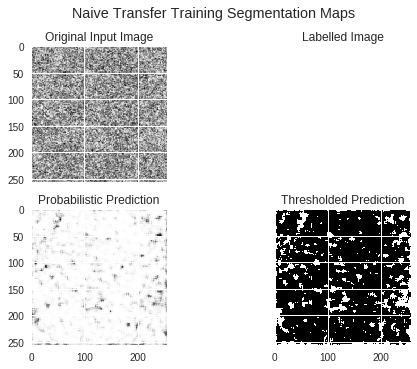

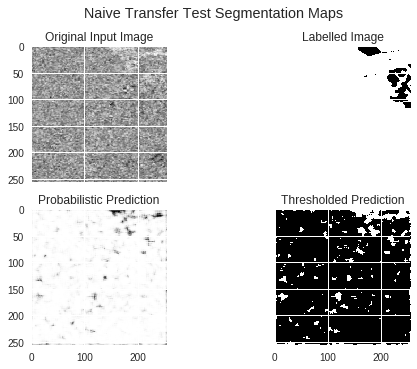

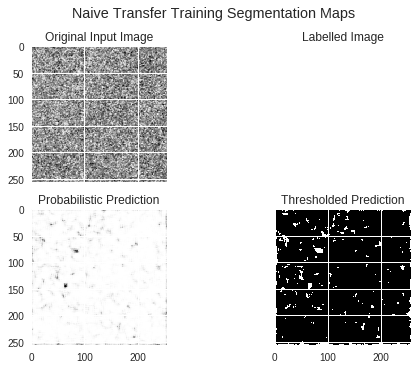

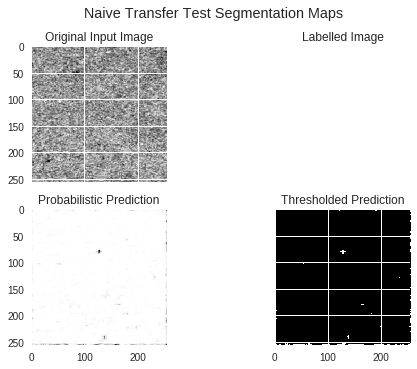

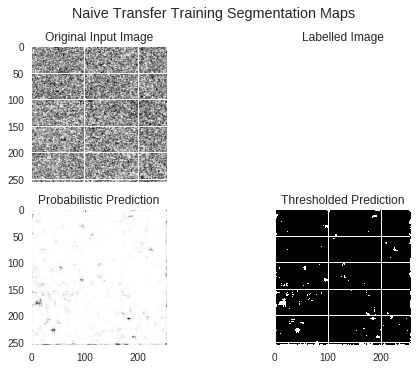

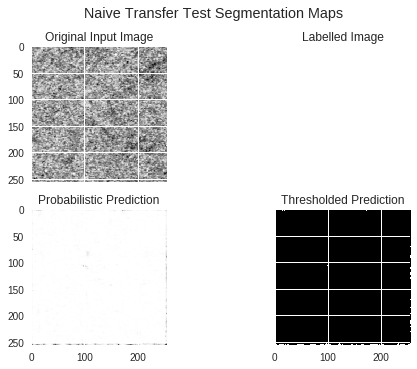

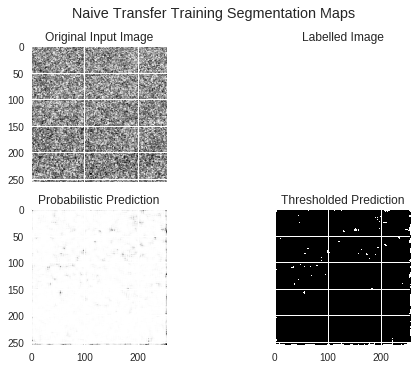

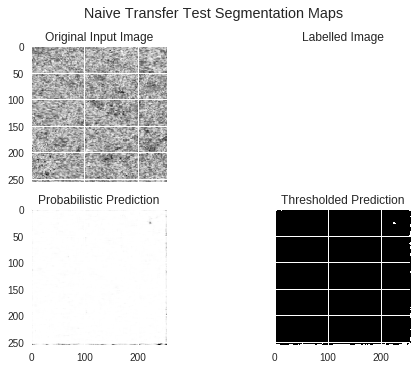

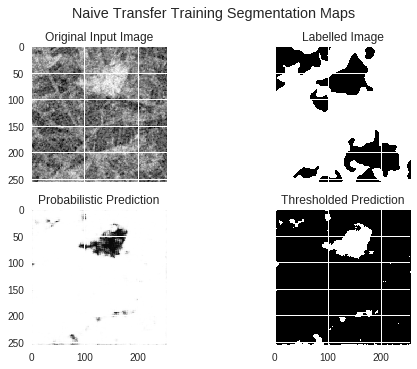

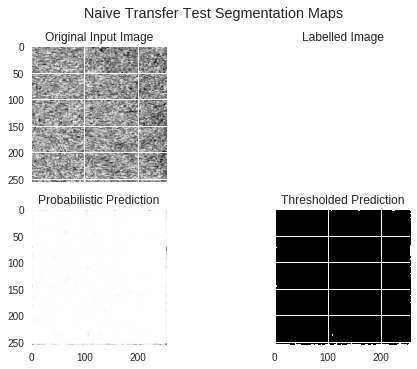

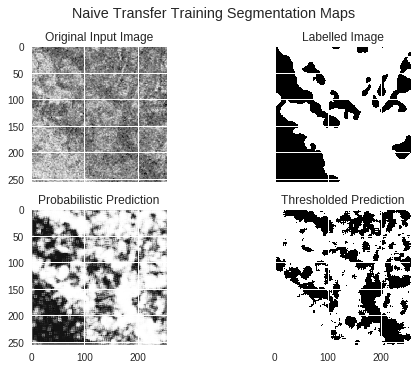

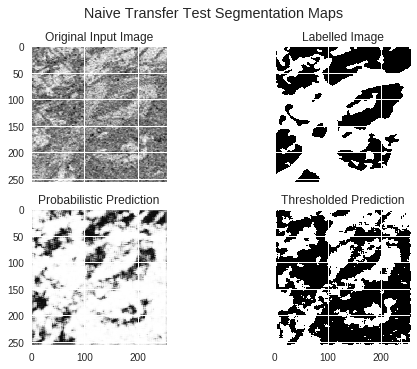

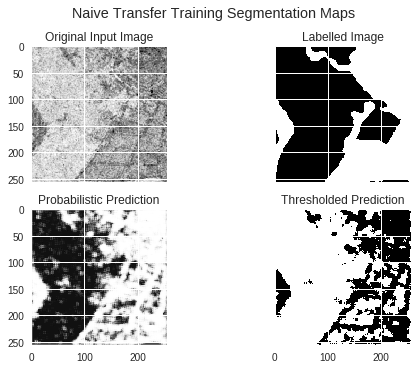

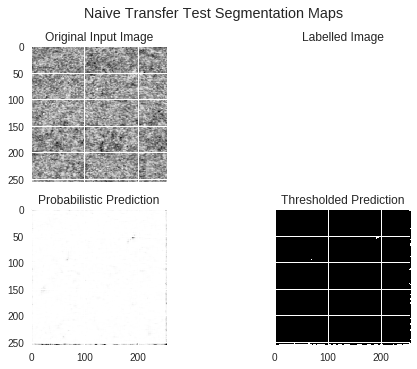

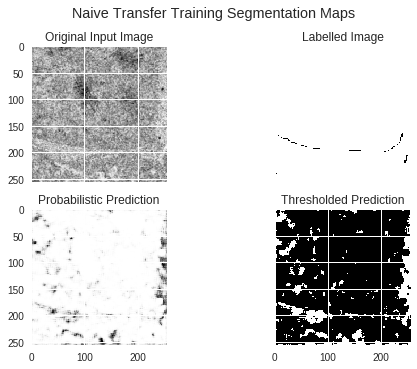

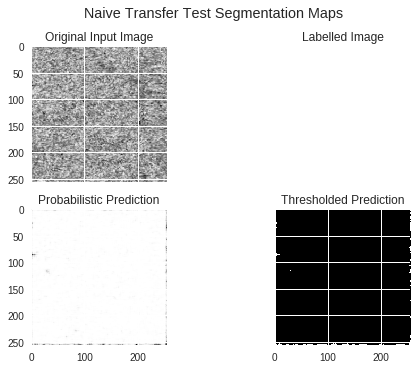

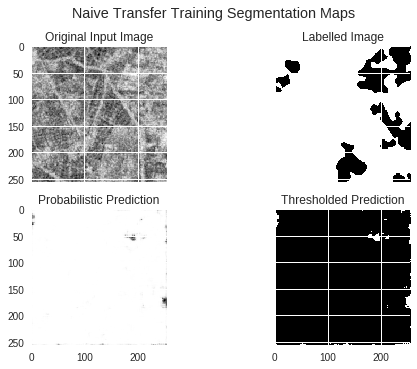

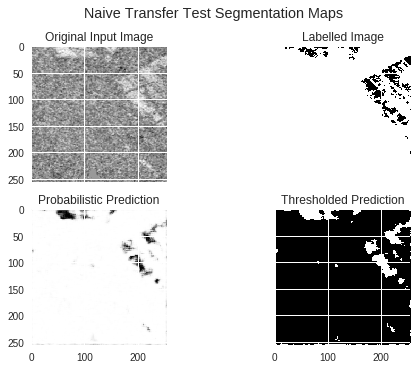

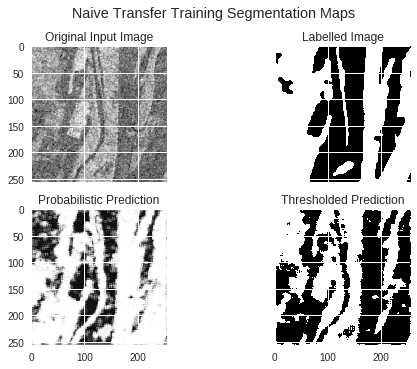

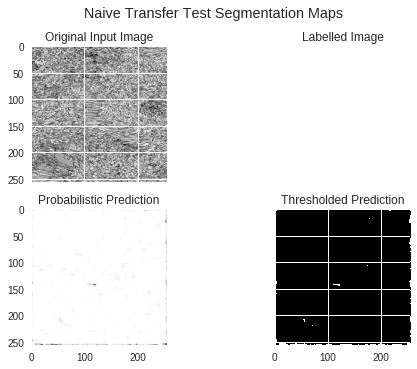

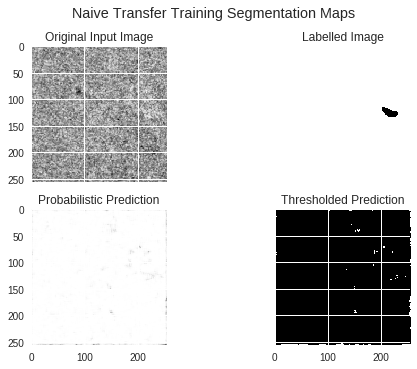

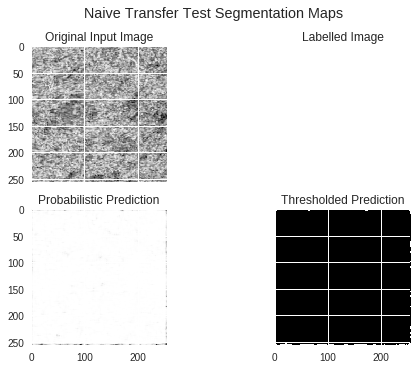

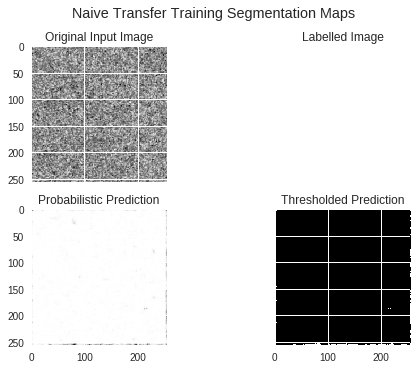

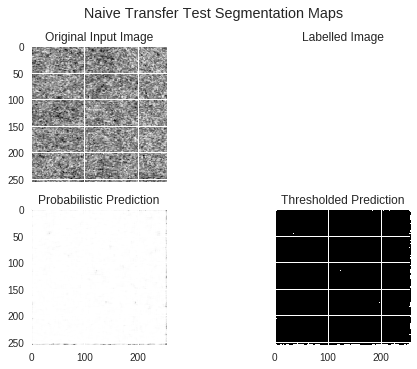

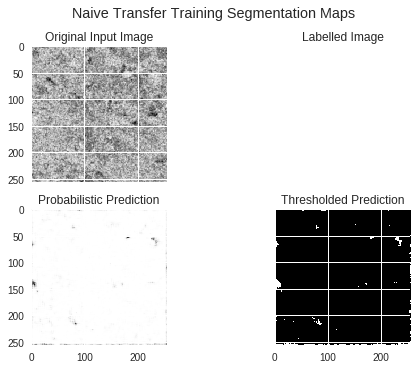

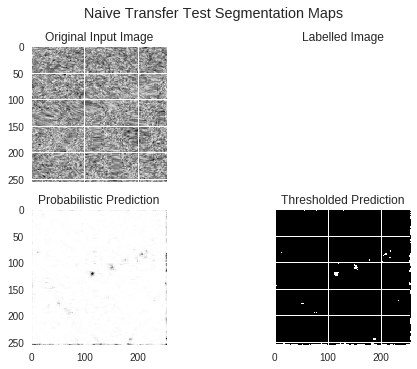

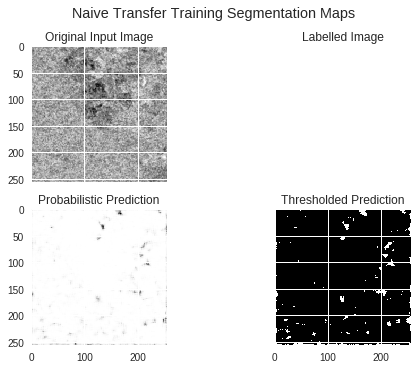

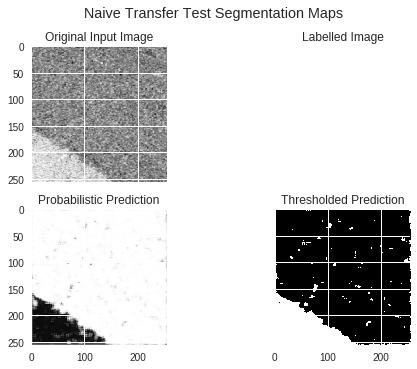

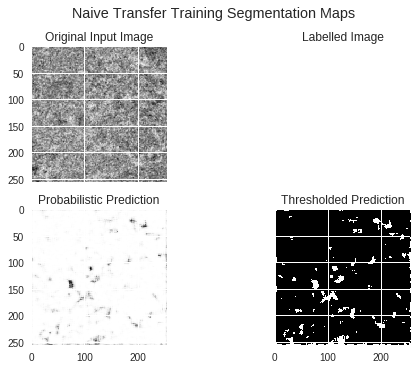

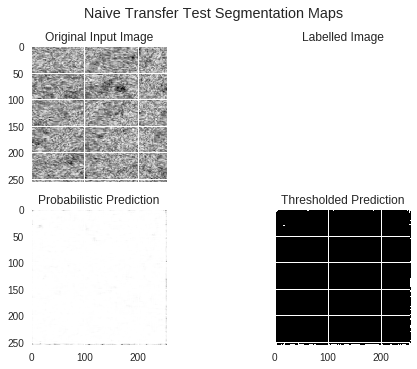

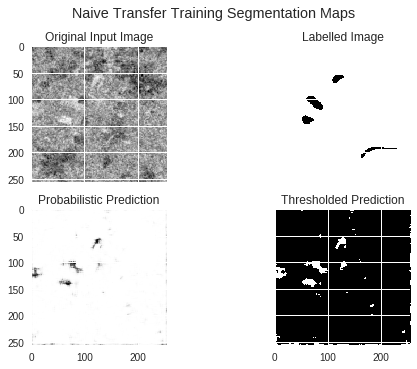

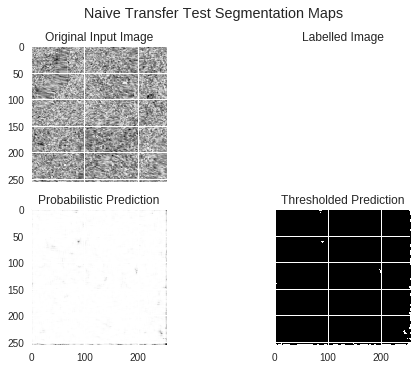

In [0]:

import datetime

batch_size = 10

train_data = train_dataset.repeat().batch(batch_size)
test_data = test_dataset.repeat().batch(batch_size)
ct = 0
for ((xb, yb), (xt,yt)) in tfe.Iterator(tf.data.Dataset.zip((train_data, test_data))):
  scenarios = ['Training','Test']
  for scenario_name in scenarios:
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
    f.suptitle(set_up+' ' +scenario_name+' Segmentation Maps')
    ax1.set_title('Original Input Image')
    ax2.set_title('Labelled Image')
    ax3.set_title('Probabilistic Prediction')
    ax4.set_title('Thresholded Prediction')
    if scenario_name == 'Training':
      x, y = xb, yb
    if scenario_name == 'Test':
      x, y = xt, yt
    
    rand_index = 9
    
    orig = tf.reshape(x[rand_index,:,:],[256,256])
    gt = tf.reshape(y[rand_index,:,:],[256,256])
    ax1.imshow(orig, cmap='Greys')
    ax2.imshow(gt,cmap=plt.cm.binary)

    predictions = get_predictions(simple_net, x)[rand_index,:,:]
#     entropy = calculate_entropy(simple_net,x,y,scenario_name)[rand_index,:,:]
    th_vector = tf.cast(tf.fill(predictions.shape,0.065),predictions.dtype)
    segmented = tf.less(predictions,th_vector)
    ax3.imshow(predictions, cmap='Greys')
    ax4.imshow(segmented, cmap=plt.cm.binary)
  ct+=1
  if ct > 40:
    break
    
   